In [1]:
# importando as bibliotecas 

import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import zipfile as zp
import io
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap as lsc
import matplotlib.ticker as mticker

import pandas as pd

# importando arquivos 
# URL do arquivo ZIP para mapa coroplético
url = "http://www.usp.br/nereus/wp-content/uploads/BR_UF_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
response = rq.get(url)
zip_file = zp.ZipFile(io.BytesIO(response.content))
zip_file.extractall("/content/brasil_estados_folder")

# Importar o shapefile
brasil_estados = gpd.read_file("/content/brasil_estados_folder/BR_UF_2021.shp")

# importando o DataSet anp meses 5 e 6

gas_eta_5=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-05.csv' ,sep=';')
gas_eta_6=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-06.csv',sep=';')
gas_eta=pd.concat([gas_eta_5,gas_eta_6])


In [2]:
gas_eta=pd.DataFrame(gas_eta,columns=['Regiao - Sigla','Estado - Sigla','Municipio','Produto','Data da Coleta','Valor de Venda','Bandeira'])
# transformando os dados da coluna valor da venda para float
gas_eta['Valor de Venda']=gas_eta['Valor de Venda'].apply(lambda x: float(x.replace(',','.')))

# transformando os dados de data para datetime
gas_eta['Data da Coleta']=pd.to_datetime(gas_eta['Data da Coleta'],dayfirst=True)



In [3]:
# mdc=media diaria dos preços combustiv
espaco_temporal = pd.date_range(start='2023-01-01', periods=30, freq='D')

In [4]:
mdc=gas_eta.pivot_table(columns='Produto',index='Data da Coleta',values='Valor de Venda', aggfunc='mean').reindex(pd.date_range(start='2023-05-01',end='2023-06-30'),method='nearest')

media_combustivel=mdc.mean()



In [6]:
media_municipal=gas_eta.pivot_table(columns='Produto',index='Municipio',values='Valor de Venda', aggfunc='mean')

municipios_mais_baratos={'GASOLINA':media_municipal['GASOLINA'].sort_values()[:3],
'GASOLINA ADITIVADA':media_municipal['GASOLINA ADITIVADA'].sort_values()[:3],
'ETANOL':media_municipal['ETANOL'].sort_values()[:3]}

gas_eta['Regiao - Sigla']


In [8]:
preco_por_regiao=gas_eta.pivot_table(columns='Regiao - Sigla',index='Produto',values='Valor de Venda', aggfunc='mean')

Regiao - Sigla,CO,N,NE,S,SE
Produto,,,,,
ETANOL,3.860694,4.717983,4.412827,4.418889,3.904152
GASOLINA,5.381720,5.779189,5.453986,5.427969,5.307980
GASOLINA ADITIVADA,5.523893,5.945986,5.594001,5.578414,5.532514


In [14]:
media_regiao_data=gas_eta.pivot_table(columns='Regiao - Sigla',values='Valor de Venda',index=['Produto','Data da Coleta'],aggfunc='mean').dropna()

In [16]:
media_regiao_data.loc['GASOLINA'].corr()

Regiao - Sigla,CO,N,NE,S,SE
Regiao - Sigla,,,,,
CO,1.000000,0.502053,0.691002,0.613359,0.692390
N,0.502053,1.000000,0.341870,0.163421,0.409093
NE,0.691002,0.341870,1.000000,0.514898,0.594370
S,0.613359,0.163421,0.514898,1.000000,0.712279
SE,0.692390,0.409093,0.594370,0.712279,1.000000


In [ ]:
percentual_g_c=F"+{((gasolina_c[gasolina_c.index.max()]/gasolina_c[gasolina_c.index.min()]-1)*100) : .2f}% Gasolina Comum".replace('.',',')
percentual_g_a =f"+{((mdc[mdc['GASOLINA ADITIVADA'].index.max()]/mdc['GASOLINA ADITIVADA'.index.min()]-1)*100): .2f}% Gasolina Aditivada".replace('.',',')
percentual_e=F"{((etanol[etanol.index.max()]/etanol[gasolina_c.index.min()]-1)*100).round(2): .2f}% Etanol".replace('.',',')

5.718

In [35]:
percentual_g_a =f"+{((mdc['GASOLINA ADITIVADA'][-1]/mdc['GASOLINA ADITIVADA'][0]-1)*100): .2f}% Gasolina Aditivada".replace('.',',')

Text(2023-07-02 00:00:00, 5.718, '+ 0,80% Gasolina Aditivada')

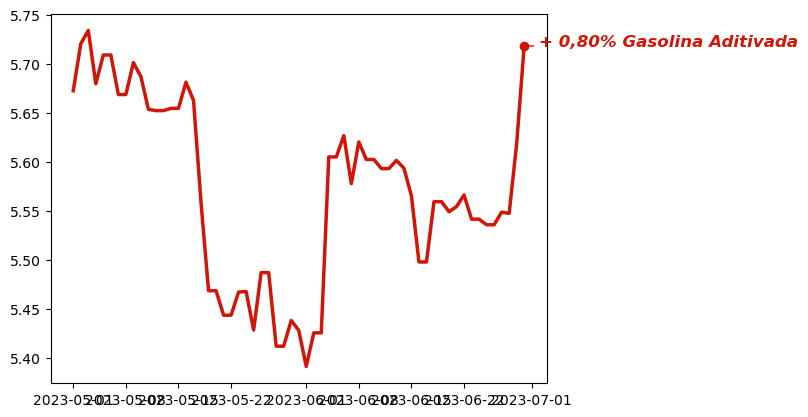

In [36]:
plt.plot(mdc.index.to_list(),mdc['GASOLINA ADITIVADA'].to_list(),color='#d11507',linewidth=2.5)
plt.scatter(mdc.index[-1],mdc['GASOLINA ADITIVADA'][-1],color='#d11507')
plt.annotate(percentual_g_a, xy=(mdc.index[-1],mdc['GASOLINA ADITIVADA'][-1]), xytext=((mdc.index[-1])+pd.Timedelta(days=2),mdc['GASOLINA ADITIVADA'][-1]),arrowprops=dict(color='#d11507', arrowstyle='-'),color='#d11507',fontsize=12,fontstyle= 'italic',fontweight= 'bold')


In [ ]:
datas_n = ['2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-06-01',  '2023-06-08', '2023-06-15', '2023-06-22', '2023-07-01']
data_e = ['1a Mai','2a Mai','3a Mai','4a Mai','1a Jun', '2a Jun', '3a Jun', '4a Jun', '1a Jul']
valor_n=[4.0,4.5,5.0,5.5]
valor_e=['R$ 4,00','R$ 4,50','R$ 5,00','R$ 5,50']

plt.figure(figsize=(8,4))

plt.plot(mdc.index.to_list(),mdc['GASOLINA ADITIVADA'].to_list(),color='#d11507',linewidth=2.5)
plt.scatter([mdc.index.max()],[mdc[mdc['GASOLINA ADITIVADA'].index.max()]],color='#d11507')
plt.annotate(percentual_g_a, xy=(mdc.index.max(),mdc[mdc['GASOLINA'].index.max()]), xytext=((mdc.index.max())+pd.Timedelta(days=2),mdc[mdc['GASOLINA ADITIVADA'].index.max()]),arrowprops=dict(color='#d11507', arrowstyle='-'),color='#d11507',fontsize=12,fontstyle= 'italic',fontweight= 'bold')

plt.plot(gasolina_c.index.to_list(),gasolina_c.to_list(),color='#a51b0b',linewidth=2.5)
plt.scatter([gasolina_c.index.max()],[gasolina_c[gasolina_c.index.max()]],color='#a51b0b')
plt.annotate(percentual_g_c, xy=(gasolina_c.index.max(),gasolina_c[gasolina_c.index.max()]), xytext=((gasolina_c.index.max())+pd.Timedelta(days=2),gasolina_c[gasolina_c.index.max()]),arrowprops=dict(color='#a51b0b', arrowstyle='-'),color='#a51b0b',fontsize=12,fontstyle= 'italic',fontweight= 'bold')

plt.plot(etanol.index.to_list(),etanol.to_list(),color='skyblue',linewidth=2.5)
plt.scatter([etanol.index.max()],[etanol[etanol.index.max()]],color='skyblue')
plt.annotate(percentual_e, xy=(etanol.index.max(),etanol[etanol.index.max()]), xytext=((etanol.index.max())+pd.Timedelta(days=2),etanol[etanol.index.max()]),arrowprops=dict(color='skyblue', arrowstyle='-'),color='DodgerBlue',fontsize=12,fontstyle= 'italic',fontweight= 'bold')

plt.gca().spines[['right','top']].set_visible(False)
plt.gca().spines[['bottom','left']].set_color('grey')
plt.xticks(datas_n,data_e,color='darkgrey')
plt.tick_params(axis='both',color='grey')
plt.yticks(valor_n,valor_e,color='grey')
plt.title('percentual de mudança nos valores do combustivel\nentre maio e junho\n\n\n',color='darkred',fontweight= 'bold',fontsize=15, fontstyle= 'italic',loc='left')
plt.show()